<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords4/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords4 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 1944, done.
remote: Counting objects: 100% (1944/1944), done.
remote: Compressing objects: 100% (1422/1422), done.
remote: Total 1944 (delta 1259), reused 982 (delta 335), pack-reused 0
Receiving objects: 100% (1944/1944), 37.35 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (1259/1259), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['keras_weighted_categorical_crossentropy.py',
 'mosaic.py',
 'patch_extractor.py',
 '__init__.py',
 'metrics.py',
 'model_best_UUnet4ConvLSTM_jun_cv_criteria_0_92',
 'mosaic.py.old',
 'densnet.py',
 'analysis',
 'dataset.py',
 'monitor.py',
 'densnet_timedistributed.py',
 'deb.py',
 'model_input_mode.py',
 'model.py',
 'generator.py',
 'main.py',
 'obj',
 'parameters']

In [6]:
from colorama import init
init()
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam,Adagrad 
from keras.models import Model
from keras import backend as K
import keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from keras.models import load_model
from keras.layers import ConvLSTM2D, UpSampling2D, multiply
from keras.utils.vis_utils import plot_model
from keras.regularizers import l1,l2
import time
import pickle
#from keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from keras.layers import Conv3DTranspose, Conv3D

from keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsRandom

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGeneratorWithCoords
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
tf.set_random_seed(2021)

from main import TrainTest

Using TensorFlow backend.
[@debug] parameters_reader.py:94 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:153 in __init__()- self.stride: 25


['parameters_openset.json', 'parameters_reader.py', 'save_nonaugmented_train_patches_lessclass8.json', '__pycache__', 'parameters_closedset_groupclasses_lessclass8.json', 'params_batchprocessing.py', '__init__.py', 'twokkc_parameters_openset.json', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'parameters_openset_specifyunknownclasses.json', 'twokkc_parameters_closedset_groupclasses.json', 'cv', 'parameters_openset_lessclass8.json', 'params_reconstruct.py', 'allkkc_parameters_openset.json', 'save_nonaugmented_train_patches.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'no_mode.json']
[@debug] paramsTrain.seq_mode = fixed
[@debug] paramsTrain.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7f9e92e960d0>


In [7]:
!nvidia-smi

Sat Jul 31 20:20:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:
from pathlib import Path

paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.getFullIms = False
paramsTrain.coordsExtract = True
paramsTrain.train = True

paramsTrain.train_overlap_percentage = 0
paramsTrain.trainGeneratorRandom = False
paramsTrain.patch_len = 32
paramsTrain.stride = int(paramsTrain.patch_len - paramsTrain.patch_len * paramsTrain.train_overlap_percentage)
paramsTrain.patch_step_train = paramsTrain.stride
paramsTrain.patch_step_test = paramsTrain.patch_len # to do: paramsTrain.getCalculatedParams() does these calculations

paramsTrain.dataset = 'cv'
paramsTrain.seq_date = 'jun'
paramsTrain.path = Path("../../../dataset/dataset/") / (paramsTrain.dataset + "_data")

paramsTrain.test_overlap_percentage = 0

paramsTrain.dataSource = SARSource()

trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	



[@debug] parameters_reader.py:94 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:153 in __init__()- self.stride: 25


['parameters_openset.json', 'parameters_reader.py', 'save_nonaugmented_train_patches_lessclass8.json', '__pycache__', 'parameters_closedset_groupclasses_lessclass8.json', 'params_batchprocessing.py', '__init__.py', 'twokkc_parameters_openset.json', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'parameters_openset_specifyunknownclasses.json', 'twokkc_parameters_closedset_groupclasses.json', 'cv', 'parameters_openset_lessclass8.json', 'params_reconstruct.py', 'allkkc_parameters_openset.json', 'save_nonaugmented_train_patches.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'no_mode.json']
[@debug] self.ds = <dataSource.CampoVerde object at 0x7f9e92ec7490>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos.shape (12, 2)
[302, 314, 326, 338, 350, 21, 45, 69, 81, 129, 141, 165]
[[0.05084 0.7197 ]
 [0.1053  0.807  ]
 [0.

[@debug] patch_extractor.py:17 in __init__()
         self.dataSource: <dataSource.SARSource object at 0x7f9e92ec7390>
[@debug] patch_extractor.py:26 in __init__()
         self.conf['path']/self.label_folder/"/": PosixPath('/')
[@debug] patch_extractor.py:35 in __init__()
         self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
[@debug] patch_extractor.py:43 in __init__()
         self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
[@debug] patch_extractor.py:44 in __init__()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


[@debug] patch_extractor.py:90 in getFullIms()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] patch_extractor.py:91 in getFullIms()
         self.dataset.im_list: ['20151029_S1',
                                '20151110_S1',
                                '20151122_S1',
                                '20151204_S1',
                                '20151216_S1',
                                '20160121_S1',
                                '20160214_S1',
                                '20160309_S1',
                                '20160321_S1',
                                '20160508_S1',
                                '20160520_S1',
                                '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


[@debug] dataSource.py:369 in im_load()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] dataSource.py:370 in im_load()
         patch["full_label_ims"].shape: (12, 8492, 7995)
[@debug] dataSource.py:371 in im_load()
         patch["full_ims"].dtype: dtype('float16')
[@debug] dataSource.py:372 in im_load()
         patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

[@debug] patch_extractor.py:127 in getFullIms()
         self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor



STARTED PATCH EXTRACTION
[@debug] gridx.shape = (320,)
[@debug] gridy.shape = (340,)


[@debug] patch_extractor.py:205 in extract()
         coords_train.shape: (8187, 2)
         coords_test.shape: (7586, 2)
[@debug] patch_extractor.py:206 in extract()
         coords_train.dtype: dtype('int64')
[@debug] patch_extractor.py:207 in extract()
         coords_train[0]: array([7566,  666])


## Train


Initializing object...
12 2
[@debug] self.channel_n = 2


[@debug] dataset.py:97 in __init__()- self.class_n: 10


[@debug] self.t_len = 12
Initializing Dataset instance


[@debug] main.py:192 in setData()- self.data.class_n: 10


Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400


[@debug] main.py:206 in setModel()- self.model.class_n: 9
[@debug] main.py:207 in setModel()- self.data.class_n: 10


[@debug] self.data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12
[@debug] output_shape = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] output_shape = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16, 16, 32)
[@debug] K.int_shape(d2) = (None, 16, 16, 32)
[@debug] output_shape = (None, 32, 32, 16)
[@debug] K.int_shape(x) = (None, 12, 32, 32, 16)
[@debug] K.int_shape(res2) = (None, 32, 32, 16)
[@debug] K.int_shape(p1) = (None, 32, 32, 16)
[@debug] K.int_shape(d1) = (None, 32, 32, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (In

[@debug] main.py:217 in preprocess()
         self.model_name: 'model_best_UUnet4ConvLSTM_jun_cv_nomode.h5'
[@debug] dataset.py:693 in create_load()
         os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:694 in create_load()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:698 in create_load()
         self.patches['train']['coords'].shape: (8187, 2)
[@debug] dataset.py:791 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))
[@debug] dataset.py:792 in labelPreprocess()
   

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


[@debug] dataset.py:850 in labelPreprocess()
         self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
         self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


[@debug] dataset.py:869 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))


Moved bcknd to last


[@debug] dataset.py:878 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                        617076,      699,    66684, 64671486]))
[@debug] dataset.py:879 in labelPreprocess()
         np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                               array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                       362633,      308,    89533, 65000618]))
[@debug] dataset.py:882 in labelPreprocess()- self.class_n: 10
[@debug] dataset.py:722 in create_load()
         self.patches['train']['label'].shape: (8187, 32, 32)
[@debug] dataset.py:723 in cr

=== SELECT VALIDATION SET FROM TRAIN SET
[@debug] self.paramsTrain.val_set_mode = random


[@debug] dataset.py:907 in val_set_get()
         self.patches['train']['n']: 8187
         self.patches['val']['n']: 1228
[@debug] dataset.py:908 in val_set_get()
         self.patches['train']['coords'].shape: (8187, 2)
[@debug] dataset.py:917 in val_set_get()
         self.patches['train']['coords'].shape: (6959, 2)
[@debug] dataset.py:918 in val_set_get()
         self.patches['val']['coords'].shape: (1228, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


[@debug] dataset.py:944 in semantic_balance()
         balance["coords"].shape: (6300, 2)
[@debug] dataset.py:948 in semantic_balance()
         np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                  array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                          617076,      699,    66684, 64671486]))
[@debug] dataset.py:954 in semantic_balance()
         coords_classes.shape: (6959, 10)
[@debug] dataset.py:956 in semantic_balance()
         unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
[@debug] dataset.py:958 in semantic_balance()- bcknd_idx: 9
[@debug] dataset.py:960 in semantic_balance()- psize: 32
[@debug] dataset.py:973 in semantic_balance()
         patch_count: array([1.741e+03, 3.014e+03, 8.400e+01, 3.220e+02, 5.700e+02, 2.010e+02,
                             1.46

[@debug] clss = 0


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 3014.0
[@debug] dataset.py:983 in semantic_balance()- clss: 1
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3945, 3014]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (3014, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 1


[@debug] dataset.py:979 in semantic_balance()- patch_count[clss]: 84.0
[@debug] dataset.py:983 in semantic_balance()- clss: 2
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6875,   84]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (84, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 2


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 322.0
[@debug] dataset.py:983 in semantic_balance()- clss: 3
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6637,  322]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (322, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 3


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 570.0
[@debug] dataset.py:983 in semantic_balance()- clss: 4
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6389,  570]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (570, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 4


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 201.0
[@debug] dataset.py:983 in semantic_balance()- clss: 5
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6758,  201]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (201, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 5


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 1463.0
[@debug] dataset.py:983 in semantic_balance()- clss: 6
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([5496, 1463]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (1463, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 6


[@debug] dataset.py:979 in semantic_balance()- patch_count[clss]: 3.0
[@debug] dataset.py:983 in semantic_balance()- clss: 7
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6956,    3]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (3, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 7


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 192.0
[@debug] dataset.py:983 in semantic_balance()- clss: 8
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (6959,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([6767,  192]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (192, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] self.data.patches['train']['coords'].shape = (6300, 2)
Instructions for updating:
Use `tf.cast` instead.


[@debug] model.py:2091 in train()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:2096 in train()- data.t_len: 12
[@debug] model.py:2097 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:2098 in train()- self.model_t_len: 12
[@debug] dataset.py:891 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] model.py:2104 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:2159 in applyFitMethod()- self.class_n: 9
[@debug] model.py:2178 in applyFitMethod()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:2179 in applyFitMethod()
         data.patches['train']['coords'][0:16]: array([[7441, 1016],
                                                       [1791, 4216],
                                                       [5741, 1466],
                                                       [1466, 4666],
                                                       [

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



[@debug] generator.py:192 in __len__()- n_batches: 393
[@debug] generator.py:192 in __len__()- n_batches: 76
[[@debug@debug]]  generatorgenerator..pypy:192: 192 inin __len__ (__len__)-() -n_batches:  n_batches393:
 76


Epoch 1/70
392/393 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.0390

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 39s 100ms/step - loss: 0.2361 - accuracy: 0.0391 - val_loss: 0.1482 - val_accuracy: 0.0540


[@debug] generator.py:192 in __len__()- [n_batches@debug:]  76generator
.py:192 in __len__()- n_batches: 76


 — val_f1: [23.53 82.97  2.92 22.44 62.2  43.23 54.2  45.54 25.19]
 — val_precision: [56.94 79.7   2.95 30.1  61.21 38.69 43.45 45.1  30.64]
 — val_recall: [14.83 86.53  2.89 17.89 63.21 48.97 72.02 46.   21.38]
 — mean_f1: 40.24666666666667
oa 61.43
Found best weights at epoch 1


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 2/70
392/393 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.1481

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 31s 78ms/step - loss: 0.1703 - accuracy: 0.1481 - val_loss: 0.0851 - val_accuracy: 0.1579


[@debug] generator.py:192 in __len__([)-@debug ]n_batches :generator .76py:
192 in __len__()- n_batches: 76


 — val_f1: [72.99 88.29 24.75 69.55 71.68 59.56 63.57 28.16 35.79]
 — val_precision: [80.31 87.39 15.36 59.83 72.5  51.55 71.77 21.87 32.1 ]
 — val_recall: [66.9  89.21 63.57 83.05 70.88 70.52 57.05 39.54 40.44]
 — mean_f1: 57.14888888888889
oa 75.16
Found best weights at epoch 2


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 3/70
392/393 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.1610

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 31s 80ms/step - loss: 0.1317 - accuracy: 0.1608 - val_loss: 0.0745 - val_accuracy: 0.1610


[@debug] generator.py:192 in __len__[@debug()]- generator n_batches.py:: 19276 
in __len__()- n_batches: 76


 — val_f1: [75.24 89.19 35.04 72.46 74.68 61.35 62.88 59.81 45.74]
 — val_precision: [81.71 87.71 21.49 60.02 75.09 52.83 78.07 50.92 38.68]
 — val_recall: [69.72 90.73 94.69 91.42 74.27 73.15 52.64 72.46 55.96]
 — mean_f1: 64.04333333333335
oa 76.9
Found best weights at epoch 3


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 4/70
392/393 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.1604

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 32s 82ms/step - loss: 0.1081 - accuracy: 0.1603 - val_loss: 0.0772 - val_accuracy: 0.1730


[@debug] generator.py:192 in __len__[(@debug)]-  generatorn_batches.:py :76192
 in __len__()- n_batches: 76


 — val_f1: [78.17 89.82 56.15 74.87 79.6  70.79 70.42 80.15 57.41]
 — val_precision: [81.81 88.52 39.8  64.39 82.32 67.44 78.52 80.15 47.46]
 — val_recall: [74.84 91.16 95.31 89.42 77.06 74.49 63.84 80.15 72.64]
 — mean_f1: 73.04222222222222
oa 80.77
Found best weights at epoch 4


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 5/70
392/393 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.1568

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 32s 81ms/step - loss: 0.0922 - accuracy: 0.1567 - val_loss: 0.0569 - val_accuracy: 0.2014


[@debug] generator.py:192 in[ @debug__len__(]) -generator .pyn_batches:: 19276 
in __len__()- n_batches: 76


 — val_f1: [80.87 90.28 76.68 78.66 84.78 84.63 72.64 67.47 71.53]
 — val_precision: [79.21 89.28 67.1  69.93 85.8  79.14 82.66 62.66 62.41]
 — val_recall: [82.6  91.31 89.44 89.89 83.78 90.94 64.79 73.08 83.76]
 — mean_f1: 78.61555555555555
oa 83.5
Found best weights at epoch 5


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 6/70
392/393 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.1569

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 33s 84ms/step - loss: 0.0799 - accuracy: 0.1569 - val_loss: 0.0515 - val_accuracy: 0.2240


[@debug] generator.py:192 in[@debug ]__len__( )generator-. n_batchespy::192  76
in __len__()- n_batches: 76


 — val_f1: [81.62 90.88 70.82 81.4  88.24 84.42 72.57 66.   76.73]
 — val_precision: [76.28 90.67 70.34 73.34 90.88 76.32 84.12 58.24 69.55]
 — val_recall: [87.76 91.1  71.31 91.44 85.74 94.44 63.81 76.15 85.58]
 — mean_f1: 79.18666666666667
oa 84.35
Found best weights at epoch 6


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 7/70
392/393 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.1602

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 33s 84ms/step - loss: 0.0706 - accuracy: 0.1602 - val_loss: 0.0485 - val_accuracy: 0.2042


[@debug] generator.py:[192@debug ]in  generator__len__.(py):-192  inn_batches :__len__ (76)
- n_batches: 76


 — val_f1: [83.69 91.92 71.11 81.09 89.84 87.06 80.15 72.74 82.32]
 — val_precision: [81.52 92.9  58.07 72.01 89.38 81.02 86.34 68.62 81.9 ]
 — val_recall: [85.98 90.97 91.7  92.79 90.3  94.07 74.8  77.38 82.75]
 — mean_f1: 82.21333333333331
oa 86.72
Found best weights at epoch 7


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 8/70
392/393 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.1630

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 34s 87ms/step - loss: 0.0638 - accuracy: 0.1629 - val_loss: 0.0435 - val_accuracy: 0.2212


[@debug] generator.py:[192@debug ]in  generator__len__.(py):-192  n_batchesin: __len__ 76(
)- n_batches: 76


 — val_f1: [84.93 92.76 75.64 83.92 90.06 89.38 82.58 86.26 82.4 ]
 — val_precision: [80.04 94.28 72.2  76.13 87.88 84.84 89.31 89.7  89.69]
 — val_recall: [90.46 91.28 79.41 93.5  92.35 94.44 76.78 83.08 76.21]
 — mean_f1: 85.32555555555555
oa 88.09
Found best weights at epoch 8


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 9/70
392/393 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.1647

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 34s 86ms/step - loss: 0.0575 - accuracy: 0.1646 - val_loss: 0.0408 - val_accuracy: 0.2156


[@debug] generator.py:192[ @debugin]  __len__generator(.py):-192  n_batchesin:  __len__76(
)- n_batches: 76


 — val_f1: [86.78 93.64 79.55 86.36 91.27 87.83 86.21 80.51 85.77]
 — val_precision: [83.51 95.22 74.69 78.66 90.22 81.84 90.04 98.01 92.04]
 — val_recall: [90.33 92.1  85.09 95.72 92.35 94.76 82.69 68.31 80.3 ]
 — mean_f1: 86.43555555555557
oa 89.82
Found best weights at epoch 9


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 10/70
392/393 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.1669

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 35s 90ms/step - loss: 0.0532 - accuracy: 0.1668 - val_loss: 0.0464 - val_accuracy: 0.1988


[@debug] generator.py:[192 @debugin]  __len__(generator).-py :n_batches192:  in76 
__len__()- n_batches: 76


 — val_f1: [86.54 94.16 69.29 86.65 91.18 83.3  86.59 70.24 85.62]
 — val_precision: [85.67 96.69 56.25 79.63 93.58 73.56 86.4  83.8  85.26]
 — val_recall: [87.42 91.76 90.19 95.03 88.89 96.01 86.79 60.46 85.97]
 — mean_f1: 83.73
oa 89.76


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 11/70
392/393 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.1685

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 35s 90ms/step - loss: 0.0488 - accuracy: 0.1684 - val_loss: 0.0362 - val_accuracy: 0.2086


[@debug] generator.[py:@debug192]  ingenerator .__len__py(:)192-  inn_batches :__len__ (76)
- n_batches: 76


 — val_f1: [88.82 95.04 77.46 89.33 92.57 90.88 88.26 84.12 87.48]
 — val_precision: [86.21 96.81 64.27 86.08 91.83 87.57 90.12 88.87 91.07]
 — val_recall: [91.59 93.32 97.46 92.84 93.32 94.46 86.47 79.85 84.15]
 — mean_f1: 88.21777777777778
oa 91.5
Found best weights at epoch 11


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 12/70
392/393 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.1694

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 35s 90ms/step - loss: 0.0452 - accuracy: 0.1694 - val_loss: 0.0351 - val_accuracy: 0.2153


[@debug] generator.py[:@debug192]  ingenerator __len__.(py):-192  inn_batches :__len__ (76)
- n_batches: 76


 — val_f1: [90.08 95.9  82.08 89.94 93.24 90.72 88.05 88.44 89.93]
 — val_precision: [87.44 97.19 72.02 83.58 92.28 87.41 92.02 85.29 89.23]
 — val_recall: [92.89 94.65 95.41 97.36 94.23 94.28 84.42 91.85 90.64]
 — mean_f1: 89.82000000000001
oa 92.31
Found best weights at epoch 12


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 13/70
392/393 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.1706

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 37s 93ms/step - loss: 0.0423 - accuracy: 0.1705 - val_loss: 0.0323 - val_accuracy: 0.2045


[@debug] generator.[py@debug:]192  generatorin. py:__len__192( )-in  n_batches__len__(: )-76 
n_batches: 76


 — val_f1: [90.27 96.29 70.62 88.41 92.93 88.   89.01 77.72 89.26]
 — val_precision: [88.79 97.08 54.94 82.21 92.14 80.57 94.26 90.41 90.98]
 — val_recall: [91.8  95.51 98.82 95.63 93.73 96.94 84.32 68.15 87.59]
 — mean_f1: 86.94555555555556
oa 92.33


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 14/70
392/393 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.1699

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 37s 94ms/step - loss: 0.0402 - accuracy: 0.1700 - val_loss: 0.0321 - val_accuracy: 0.1928


[@debug] generator[@debug.py]:192  generatorin. py__len__:(192) -in n_batches :__len__ (76)
- n_batches: 76


 — val_f1: [89.66 95.85 74.41 89.25 93.91 89.31 89.94 88.19 89.71]
 — val_precision: [90.14 96.99 59.41 83.29 93.54 84.22 91.2  95.19 90.5 ]
 — val_recall: [89.18 94.73 99.55 96.13 94.27 95.07 88.71 82.15 88.94]
 — mean_f1: 88.91444444444444
oa 92.41


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 15/70
392/393 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.1693

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 38s 96ms/step - loss: 0.0378 - accuracy: 0.1694 - val_loss: 0.0304 - val_accuracy: 0.2053


[@debug] [generator@debug.]py :generator192. pyin :__len__192( )in-  __len__n_batches(:) 76-
 n_batches: 76


 — val_f1: [91.6  96.74 91.09 90.76 94.48 88.28 91.07 81.49 91.08]
 — val_precision: [90.56 97.37 84.08 85.72 95.5  81.61 93.15 96.03 89.62]
 — val_recall: [92.66 96.12 99.36 96.42 93.47 96.14 89.08 70.77 92.59]
 — mean_f1: 90.73222222222222
oa 93.8
Found best weights at epoch 15


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 16/70
392/393 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.1706

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 38s 97ms/step - loss: 0.0355 - accuracy: 0.1707 - val_loss: 0.0295 - val_accuracy: 0.2029


[@debug] [generator@debug.]py :192generator .inpy :192__len__ ()in- __len__ (n_batches): -76 
n_batches: 76


 — val_f1: [91.56 95.92 75.49 91.   93.61 89.45 90.01 73.99 92.32]
 — val_precision: [90.34 96.74 61.06 85.41 91.99 83.21 94.19 81.37 94.59]
 — val_recall: [92.81 95.12 98.85 97.38 95.29 96.7  86.19 67.85 90.15]
 — mean_f1: 88.14999999999999
oa 92.98


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 17/70
392/393 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.1713

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 39s 100ms/step - loss: 0.0346 - accuracy: 0.1712 - val_loss: 0.0281 - val_accuracy: 0.2005


[@debug] generator[.@debugpy]: 192generator .inpy __len__:192( )in-  __len__n_batches:( )76-
 n_batches: 76


 — val_f1: [92.09 96.72 86.56 89.97 94.6  89.23 91.43 81.37 90.13]
 — val_precision: [92.17 97.19 76.66 83.79 95.64 83.22 93.51 89.03 86.77]
 — val_recall: [92.   96.26 99.39 97.13 93.58 96.17 89.43 74.92 93.76]
 — mean_f1: 90.23333333333333
oa 93.86


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 18/70
392/393 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.1718

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 40s 102ms/step - loss: 0.0326 - accuracy: 0.1719 - val_loss: 0.0280 - val_accuracy: 0.2027


[@debug] [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches:) -76 
n_batches: 76


 — val_f1: [91.84 96.34 84.83 90.08 94.01 87.99 90.73 71.71 90.54]
 — val_precision: [90.81 96.7  75.53 87.3  95.35 80.41 93.3  99.18 85.83]
 — val_recall: [92.9  95.99 96.73 93.03 92.71 97.14 88.3  56.15 95.79]
 — mean_f1: 88.67444444444443
oa 93.44


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 19/70
392/393 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.1697

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 40s 101ms/step - loss: 0.0309 - accuracy: 0.1698 - val_loss: 0.0280 - val_accuracy: 0.1879


[@debug][ @debuggenerator]. generatorpy.:py192: 192in  in__len__ (__len__)(-) -n_batches: n_batches :76 
76


 — val_f1: [91.59 96.63 89.23 90.03 93.96 88.28 90.5  71.02 91.4 ]
 — val_precision: [92.93 96.63 83.92 86.49 94.27 81.01 91.33 94.39 87.85]
 — val_recall: [90.29 96.62 95.25 93.87 93.64 96.99 89.68 56.92 95.24]
 — mean_f1: 89.18222222222222
oa 93.55


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 20/70
392/393 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.1708

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 40s 102ms/step - loss: 0.0306 - accuracy: 0.1708 - val_loss: 0.0274 - val_accuracy: 0.1819


[@debug] generator[.@debugpy]: 192generator .inpy :__len__192() -in  n_batches__len__:( )76
- n_batches: 76


 — val_f1: [92.07 96.4  79.79 89.78 93.49 90.35 90.96 62.14 86.71]
 — val_precision: [ 94.54  96.58  68.55  83.53  90.13  84.19  92.28 100.    96.4 ]
 — val_recall: [89.74 96.22 95.43 97.05 97.12 97.48 89.67 45.08 78.79]
 — mean_f1: 86.85444444444444
oa 93.4


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 21/70
392/393 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.1711

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 42s 106ms/step - loss: 0.0298 - accuracy: 0.1712 - val_loss: 0.0275 - val_accuracy: 0.1857


[@debug] [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ n_batches():-  76n_batches
: 76


 — val_f1: [92.09 96.55 81.44 89.18 93.19 89.12 90.65 73.07 82.63]
 — val_precision: [94.1  96.21 72.41 83.9  97.74 82.16 92.06 87.72 72.05]
 — val_recall: [90.17 96.88 93.03 95.17 89.05 97.36 89.28 62.62 96.84]
 — mean_f1: 87.54666666666667
oa 93.27


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 22/70
392/393 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.1715

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 43s 109ms/step - loss: 0.0289 - accuracy: 0.1715 - val_loss: 0.0233 - val_accuracy: 0.1968


[@debug] [generator@debug.]py :generator192 .pyin: 192__len__ (in) -__len__ (n_batches):-  n_batches76:
 76


 — val_f1: [92.5  97.05 87.44 90.06 93.21 88.8  92.87 74.14 88.98]
 — val_precision: [92.56 98.13 78.76 83.65 93.12 82.1  94.38 98.22 83.6 ]
 — val_recall: [92.43 95.99 98.27 97.53 93.3  96.68 91.4  59.54 95.09]
 — mean_f1: 89.44999999999999
oa 94.22


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 23/70
392/393 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.1697

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 43s 110ms/step - loss: 0.0276 - accuracy: 0.1698 - val_loss: 0.0231 - val_accuracy: 0.2049


[@debug][ generator@debug.]py :generator192. py:in192  __len__in( )__len__-( n_batches)-:  n_batches76:
 76


 — val_f1: [92.16 96.7  88.54 89.77 94.18 87.89 92.62 50.22 92.21]
 — val_precision: [91.24 98.18 85.16 84.59 95.01 80.26 92.96 92.56 88.35]
 — val_recall: [93.1  95.26 92.2  95.64 93.36 97.11 92.29 34.46 96.43]
 — mean_f1: 87.14333333333333
oa 94.07


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 24/70
392/393 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.1689

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 44s 111ms/step - loss: 0.0268 - accuracy: 0.1689 - val_loss: 0.0276 - val_accuracy: 0.1960


[@debug][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches-:  n_batches76
: 76


 — val_f1: [92.85 96.45 75.05 90.36 91.82 91.82 92.85 75.77 79.24]
 — val_precision: [93.84 98.2  60.27 84.58 94.4  87.75 92.86 77.8  67.56]
 — val_recall: [91.88 94.76 99.42 96.99 89.37 96.29 92.85 73.85 95.8 ]
 — mean_f1: 87.35666666666667
oa 93.56


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 25/70
392/393 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.1724

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 44s 112ms/step - loss: 0.0259 - accuracy: 0.1724 - val_loss: 0.0243 - val_accuracy: 0.1880


[@debug][ @debuggenerator]. pygenerator.:py192 :192in  in__len__ (__len__)(-) -n_batches :n_batches :76 
76


 — val_f1: [91.32 97.21 89.7  89.7  95.37 92.8  91.85 68.51 92.34]
 — val_precision: [92.91 98.19 87.63 84.06 93.65 88.97 91.01 95.59 92.09]
 — val_recall: [89.79 96.25 91.87 96.15 97.16 96.97 92.7  53.38 92.6 ]
 — mean_f1: 89.86666666666667
oa 94.19
Restoring model weights from the end of the best epoch.
Epoch %05d: early stopping
f1 history [40.24666666666667, 57.14888888888889, 64.04333333333335, 73.04222222222222, 78.61555555555555, 79.18666666666667, 82.21333333333331, 85.32555555555555, 86.43555555555557, 83.73, 88.21777777777778, 89.82000000000001, 86.94555555555556, 88.91444444444444, 90.73222222222222, 88.14999999999999, 90.23333333333333, 88.67444444444443, 89.18222222222222, 86.85444444444444, 87.54666666666667, 89.44999999999999, 87.14333333333333, 87.35666666666667, 89.86666666666667]
oa history [61.43, 75.16, 76.9, 80.77, 83.5, 84.35, 86.72, 88.09, 89.82, 89.76, 91.5, 92.31, 92.33, 92.41, 93.8, 92.98, 93.86, 93.44, 93.55, 93.4, 93.27, 94.22, 94.07, 93.56, 94.19]


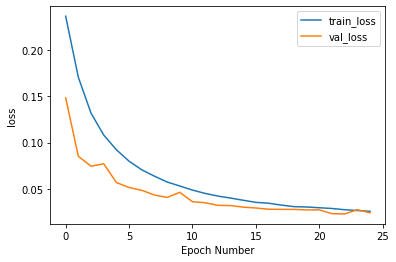

In [12]:

model_name_id = 'model_best_' + paramsTrain.model_type + '_' + \
    paramsTrain.seq_date + '_' + paramsTrain.dataset + '_' + \
    paramsTrain.model_name + '.h5'


trainTest.setData()
trainTest.setModel()

trainTest.preprocess(model_name_id) # move into if
if paramsTrain.train == True:
  trainTest.train()
else:
  trainTest.modelLoad(model_name_id)



## Evaluate


In [13]:
trainTest.evaluate()

[@debug] dataset.py:1067 in loadMask()
         str(self.paramsTrain.path): '../../../dataset/dataset/cv_data'
[@debug] dataset.py:1069 in loadMask()- self.mask.shape: (8492, 7995)
[@debug] dataset.py:891 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] params_reconstruct.py:42 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] params_reconstruct.py:42 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] mosaic.py:44 in __init__()- paramsTrain.seq_date: 'jun'


[@debug] dataset = cv
[@debug] paramsTrain.model_type = unet


[@debug] mosaic.py:70 in create()- data.class_n: 10
[@debug] mosaic.py:71 in create()
         np.unique(data.full_label_test): array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8)
         len(np.unique(data.full_label_test)): 10
[@debug] mosaic.py:72 in create()
         np.unique(data.full_label_train): array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
         len(np.unique(data.full_label_train)): 10
[@debug] mosaic.py:122 in create()
         prediction_mosaic.shape: (8492, 7995)
         mask_pad.shape: (8492, 7995)
         data.full_label_test.shape: (8492, 7995)
[@debug] mosaic.py:123 in create()
         np.unique(data.full_label_test, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                               array([65000618,   730790,  1199149,    25986,    88785,   312353,
                                                                        83385,   362633,      308,    89533]))
[@debug] mo

Entering newLabel2labelTranslate
[@debug] np.unique(label,return_counts=True) = (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
[@debug] np.unique(label)[-1] = 8
[@debug] np.unique(label,return_counts=True) = (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
[@debug] np.unique(label,return_counts=True) = (array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
new_labels2labels filename <_io.BufferedReader name='new_labels2labels_cv_20160613_S1.pkl'>
[@debug] new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}
[@debug] classes = [1 2 3 4 5 6 7 8 9]
1
Translated 2
2
Translated 3
3
Translated 4
4
Translated 6
5
Translated 7
6
Translated 8
7
Translate

[@debug] mosaic.py:157 in create()
         np.unique(prediction_mosaic, return_counts=True): (array([ 2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                            array([64216186,  1790127,    86312,   221580,   461213,   259551,
                                                                    650434,     3613,   204524]))
[@debug] mosaic.py:160 in create()
         data.full_label_test.shape: (8492, 7995)
[@debug] mosaic.py:161 in create()
         np.unique(data.full_label_test, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                               array([65000618,   730790,  1199149,    25986,    88785,   312353,
                                                                        83385,   362633,      308,    89533]))
[@debug] mosaic.py:163 in create()
         np.unique(label_mosaic, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11]

[@debug] important_classes_idx = [1, 2, 3, 5, 6, 7, 8, 9, 10]
[@debug] np.unique(label,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(predictions,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
[@debug] np.unique(label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(prediction_mosaic,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
[@debug] label_mo

[@debug] mosaic.py:189 in create()
         data.mask.shape: (8492, 7995)
         mask_pad.shape: (8492, 7995)
         label_mosaic.shape: (8492, 7995)
         prediction_mosaic.shape: (8492, 7995)
[@debug] mosaic.py:202 in save_prediction_label_mosaic_Nto1()
         np.unique(mask, return_counts=True): (array([0, 1, 2], dtype=uint8), array([61778564,  3222054,  2892922]))


[@debug] np.unique(label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(prediction_mosaic,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64216186,  1790127,    86312,   221580,   461213,   259551,
         650434,     3613,   204524]))
everything outside mask is 255


[@debug] mosaic.py:213 in save_prediction_label_mosaic_Nto1()
         np.unique(label_mosaic,return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                      array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                              362633,      308,    89533, 65000618]))
[@debug] mosaic.py:214 in save_prediction_label_mosaic_Nto1()
         np.unique(prediction_mosaic,return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                           array([64216186,  1790127,    86312,   221580,   461213,   259551,
                                                                   650434,     3613,   204524]))


(11, 3)
Gray uint8
Adding color...
RGB uint8 (8492, 7995, 3)
[@debug] custom_colormap = [[255 146  36]
 [255 255   0]
 [164 164 164]
 [255  62  62]
 [  0   0   0]
 [172  89 255]
 [  0 166  83]
 [ 40 255  40]
 [187 122  83]
 [217  64 238]
 [ 45 150 255]]
Assigning color...
RGB uint8 (8492, 7995, 3)
Saving the resulting images...
[@debug] save_folder = results/spatial_results/cv/unet/jun


[@debug] mosaic.py:276 in save_prediction_label_mosaic_Nto1()
         prediction_savename: PosixPath('results/spatial_results/cv/unet/jun/prediction_t_jun_unet_closedset_closed_set_overl0_test.png')


saving...
no file to remove
[@debug] ret = True


[@debug] mosaic.py:286 in save_prediction_label_mosaic_Nto1()
         save_folder / ("label_t_"+paramsTrain.seq_date+"_"+paramsTrain.model_type+"_"+name_id+".png"): PosixPath('results/spatial_results/cv/unet/jun/label_t_jun_unet_closed_set.png')


[@debug] ret = True
[@debug] ret = True
======================= METRICS GET


[@debug] metrics.py:31 in get()
         prediction.shape: (8492, 7995)
         label.shape: (8492, 7995)
[@debug] metrics.py:32 in get()
         np.unique(prediction, return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                     array([64216186,  1790127,    86312,   221580,   461213,   259551,
                                                             650434,     3613,   204524]))
[@debug] metrics.py:33 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))
[@debug] metrics.py:34 in get()
         len(np.unique(label, return_counts=True)): 2
[@debug] metrics.py:39 in get()- class_n: 9


[@debug] prediction.shape,debug,2 = (8492, 7995)
[@debug] label.shape,debug,2 = (8492, 7995)
[@debug] prediction.shape = (8492, 7995)
[@debug] prediction.shape = (67893540,)


[@debug] metrics.py:67 in get()
         np.unique(prediction, return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                     array([64216186,  1790127,    86312,   221580,   461213,   259551,
                                                             650434,     3613,   204524]))
[@debug] metrics.py:68 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))


Metric label unique+1,count [ 2  3  4  6  7  8  9 10 11] [ 730790 1199149   25986   88785  312353   83385  362633     308   89533]
Metric prediction unique+1,count [ 2  3  4  6  7  8  9 10 11] [ 686189 1182801   45070  142324  212888  101480  417404     456  104310]
[@debug] metrics_test = {'f1_score': 0.6194929438106419, 'f1_score_weighted': 0.7604218683817516, 'f1_score_noavg': array([0.68272289, 0.91030542, 0.40734069, 0.51525471, 0.67111669,
       0.88159468, 0.57612908, 0.2513089 , 0.67966344]), 'overall_acc': 0.7571144330887594, 'confusion_matrix': array([[ 483702,   52061,   17646,   13517,    7515,     857,  153629,
            147,    1716],
       [  65641, 1084151,    5104,   10239,    6321,    3131,   23065,
              1,    1496],
       [   3791,    1099,   14472,     242,     230,       0,    6152,
              0,       0],
       [  13762,    4024,    1981,   59540,    1860,    1041,    5779,
             90,     708],
       [  25072,    3722,    5027,   52802,  1